# 🛡️ CyberX URL Threat Detection — Model Training & Evaluation

This notebook trains and evaluates machine learning models for URL threat classification.

**Pipeline:** Data Loading → Feature Engineering → Model Training → Evaluation → Export

**Models:** Decision Tree · Random Forest · Extra Trees  
**Features:** 20 engineered features per URL  
**Dataset:** Cisco Umbrella Top-1M (legitimate) + OpenPhish & PhishTank (phishing)  
**Classification:** Binary — Safe (0) vs Phishing (1)

## 1 · Data Acquisition

In [1]:
import io, os, zipfile, requests
import pandas as pd

DATA_DIR = os.path.join(os.getcwd(), 'Dataset')
os.makedirs(DATA_DIR, exist_ok=True)

# ── 1a. Cisco Umbrella Top 1M (legitimate URLs) ──────────────────────────
umbrella_path = os.path.join(DATA_DIR, 'top-1m.csv')
if not os.path.exists(umbrella_path):
    print("⬇️  Downloading Cisco Umbrella Top 1M …")
    r = requests.get('http://s3-us-west-1.amazonaws.com/umbrella-static/top-1m.csv.zip')
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        z.extractall(DATA_DIR)
    print(f"✅  Saved to {umbrella_path}")
else:
    print(f"✅  Umbrella file already exists: {umbrella_path}")

# ── 1b. OpenPhish feed (phishing URLs) ───────────────────────────────────
openphish_path = os.path.join(DATA_DIR, 'openphish_feed.txt')
print("⬇️  Fetching OpenPhish feed …")
r = requests.get('https://raw.githubusercontent.com/openphish/public_feed/refs/heads/main/feed.txt')
with open(openphish_path, 'w', encoding='utf-8') as f:
    f.write(r.text)
op_count = len([l for l in r.text.strip().splitlines() if l.strip()])
print(f"✅  OpenPhish: {op_count} URLs saved")

# ── 1c. PhishTank feed (phishing URLs) ───────────────────────────────────
phishtank_path = os.path.join(DATA_DIR, 'phishtank_feed.csv')
print("⬇️  Fetching PhishTank feed …")
r = requests.get('http://data.phishtank.com/data/online-valid.csv')
with open(phishtank_path, 'wb') as f:
    f.write(r.content)
print(f"✅  PhishTank: saved to {phishtank_path}")

print("\n📦  All datasets downloaded.")

⬇️  Downloading Cisco Umbrella Top 1M …
✅  Saved to d:\GitHub\Backend Development\Django\Project\CyberX\Services\URL threat scanning\Dataset\top-1m.csv
⬇️  Fetching OpenPhish feed …
✅  OpenPhish: 300 URLs saved
⬇️  Fetching PhishTank feed …
✅  PhishTank: saved to d:\GitHub\Backend Development\Django\Project\CyberX\Services\URL threat scanning\Dataset\phishtank_feed.csv

📦  All datasets downloaded.


In [2]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore
from urllib.parse import urlparse
from tld import get_tld, is_tld
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB

## 2 · Data Loading & Unified Binary DataFrame

In [3]:
# ── Load Cisco Umbrella (legitimate) ──────────────────────────────────────
umbrella = pd.read_csv(
    os.path.join(DATA_DIR, 'top-1m.csv'),
    names=['rank', 'domain'], header=None
)
# Convert bare domains to full URLs
umbrella['url'] = 'http://' + umbrella['domain']
umbrella['label'] = 0  # Safe
# Take top 50K for faster training (increase if desired)
umbrella = umbrella.head(50_000)[['url', 'label']]
print(f"✅  Umbrella (Safe):   {len(umbrella):,}")

# ── Load OpenPhish (phishing) ─────────────────────────────────────────────
with open(os.path.join(DATA_DIR, 'openphish_feed.txt'), 'r', encoding='utf-8') as f:
    op_urls = [l.strip() for l in f if l.strip()]
openphish = pd.DataFrame({'url': op_urls, 'label': 1})
print(f"✅  OpenPhish (Phishing): {len(openphish):,}")

# ── Load PhishTank (phishing) ─────────────────────────────────────────────
try:
    pt = pd.read_csv(os.path.join(DATA_DIR, 'phishtank_feed.csv'), usecols=['url'])
    pt['label'] = 1
    print(f"✅  PhishTank (Phishing): {len(pt):,}")
except Exception as e:
    print(f"⚠️  PhishTank parse issue ({e}) — skipping")
    pt = pd.DataFrame(columns=['url', 'label'])

# ── Merge & deduplicate ──────────────────────────────────────────────────
data = pd.concat([umbrella, openphish, pt], ignore_index=True)
data.drop_duplicates(subset='url', inplace=True)
data.reset_index(drop=True, inplace=True)

# Binary labels: 0 = Safe, 1 = Phishing
data['Category'] = data['label']
data['type'] = data['label'].map({0: 'Safe', 1: 'Phishing'})

print(f"\n📊  Combined dataset: {len(data):,} URLs")
data.head()

✅  Umbrella (Safe):   50,000
✅  OpenPhish (Phishing): 300
✅  PhishTank (Phishing): 56,301

📊  Combined dataset: 106,585 URLs


,url,label,Category,type
0,http://google.com,0,0,Safe
1,http://microsoft.com,0,0,Safe
2,http://www.google.com,0,0,Safe
3,http://data.microsoft.com,0,0,Safe
4,http://events.data.microsoft.com,0,0,Safe


In [4]:
count = data['type'].value_counts()
count

type
Phishing    56585
Safe        50000
Name: count, dtype: int64

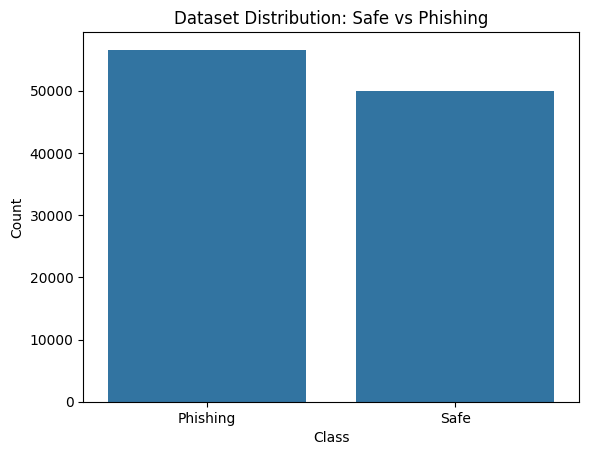

In [5]:
sns.barplot(x=count.index, y=count.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Dataset Distribution: Safe vs Phishing');

In [6]:
data['url'] = data['url'].replace('www.', '', regex=True)
data

,url,label,Category,type
0,http://google.com,0,0,Safe
1,http://microsoft.com,0,0,Safe
2,http://google.com,0,0,Safe
3,http://data.microsoft.com,0,0,Safe
4,http://events.data.microsoft.com,0,0,Safe
...,...,...,...,...
106580,http://webmailadmin0.myfreesites.net/,1,1,Phishing
106581,http://formbuddy.com/cgi-bin/formdisp.pl?u=Twi...,1,1,Phishing
106582,http://formbuddy.com/cgi-bin/formdisp.pl?u=sec...,1,1,Phishing
106583,http://habbocreditosparati.blogspot.com/,1,1,Phishing


In [7]:
# Category is already 0/1 — verify
print("Label distribution:")
print(data['Category'].value_counts())
print(f"\n0 = Safe, 1 = Phishing")

Label distribution:
Category
1    56585
0    50000
Name: count, dtype: int64

0 = Safe, 1 = Phishing


## 3 · Feature Engineering

Extracting 20 features from each URL: length, special characters, domain analysis, security indicators, and more.

In [8]:
data['url_len'] = data['url'].apply(lambda x: len(str(x)))

In [9]:
def process_tld(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain

In [10]:
data['domain'] = data['url'].apply(lambda i: process_tld(i))

In [11]:
data.head()

,url,label,Category,type,url_len,domain
0,http://google.com,0,0,Safe,17,None
1,http://microsoft.com,0,0,Safe,20,None
2,http://google.com,0,0,Safe,17,None
3,http://data.microsoft.com,0,0,Safe,25,None
4,http://events.data.microsoft.com,0,0,Safe,32,None


In [12]:
feature = ['@','?','-','=','.','#','%','+','$','!','*',',','//']
for a in feature:
    data[a] = data['url'].apply(lambda i: i.count(a))

In [13]:
data.head()

,url,label,Category,type,url_len,domain,@,?,-,=,.,#,%,+,$,!,*,",",//
0,http://google.com,0,0,Safe,17,None,0,0,0,0,1,0,0,0,0,0,0,0,1
1,http://microsoft.com,0,0,Safe,20,None,0,0,0,0,1,0,0,0,0,0,0,0,1
2,http://google.com,0,0,Safe,17,None,0,0,0,0,1,0,0,0,0,0,0,0,1
3,http://data.microsoft.com,0,0,Safe,25,None,0,0,0,0,2,0,0,0,0,0,0,0,1
4,http://events.data.microsoft.com,0,0,Safe,32,None,0,0,0,0,3,0,0,0,0,0,0,0,1


In [14]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [15]:
data['abnormal_url'] = data['url'].apply(lambda i: abnormal_url(i))

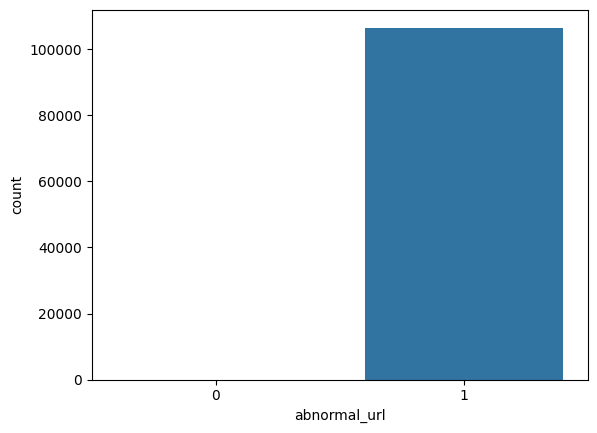

In [16]:
sns.countplot(x='abnormal_url', data=data);

In [17]:
def httpSecure(url):
    htp = urlparse(url).scheme
    match = str(htp)
    if match=='https':
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0

In [18]:
data['https'] = data['url'].apply(lambda i: httpSecure(i))

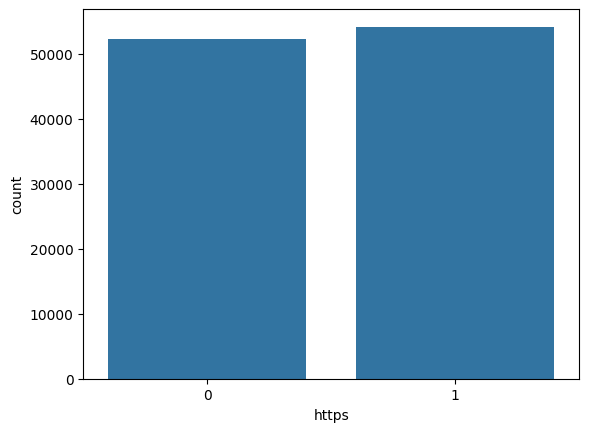

In [19]:
sns.countplot(x='https', data=data);

In [20]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits

In [21]:
data['digits']= data['url'].apply(lambda i: digit_count(i))

In [22]:
def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters

In [23]:
data['letters']= data['url'].apply(lambda i: letter_count(i))

In [24]:
def Shortining_Service(url):
    """
    Returns 1 if the URL uses a known shortening service, else 0.
    """
    match = re.search(
        r'bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
        r'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
        r'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
        r'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
        r'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
        r'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
        r'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
        r'tr\.im|link\.zip\.net',
        url
    )
    return 1 if match else 0

In [25]:
data['Shortining_Service'] = data['url'].apply(lambda x: Shortining_Service(x))

<Axes: xlabel='Shortining_Service', ylabel='count'>

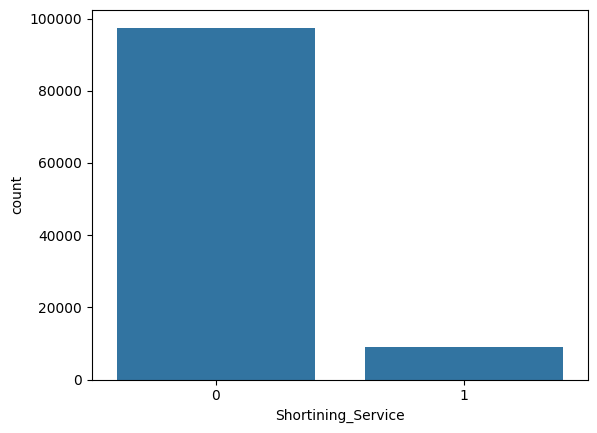

In [26]:
sns.countplot(x='Shortining_Service', data=data)

In [27]:
def having_ip_address(url):
    """
    Returns 1 if the URL contains an IP address (IPv4, IPv6, or hexadecimal), else 0.
    """
    match = re.search(
        r'(([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.([01]?\d\d?|2[0-4]\d|25[0-5])\.'
        r'([01]?\d\d?|2[0-4]\d|25[0-5]))|'  # IPv4
        r'((0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2})\.(0x[0-9a-fA-F]{1,2}))|'  # IPv4 in hex
        r'(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}|'  # IPv6
        r'([0-9]+(?:\.[0-9]+){3}:[0-9]+)',  # IPv4 with port
        url
    )
    return 1 if match else 0

In [28]:
data['having_ip_address'] = data['url'].apply(lambda i: having_ip_address(i))

In [29]:
data['having_ip_address'].value_counts()

having_ip_address
0    106418
1       167
Name: count, dtype: int64

<Axes: >

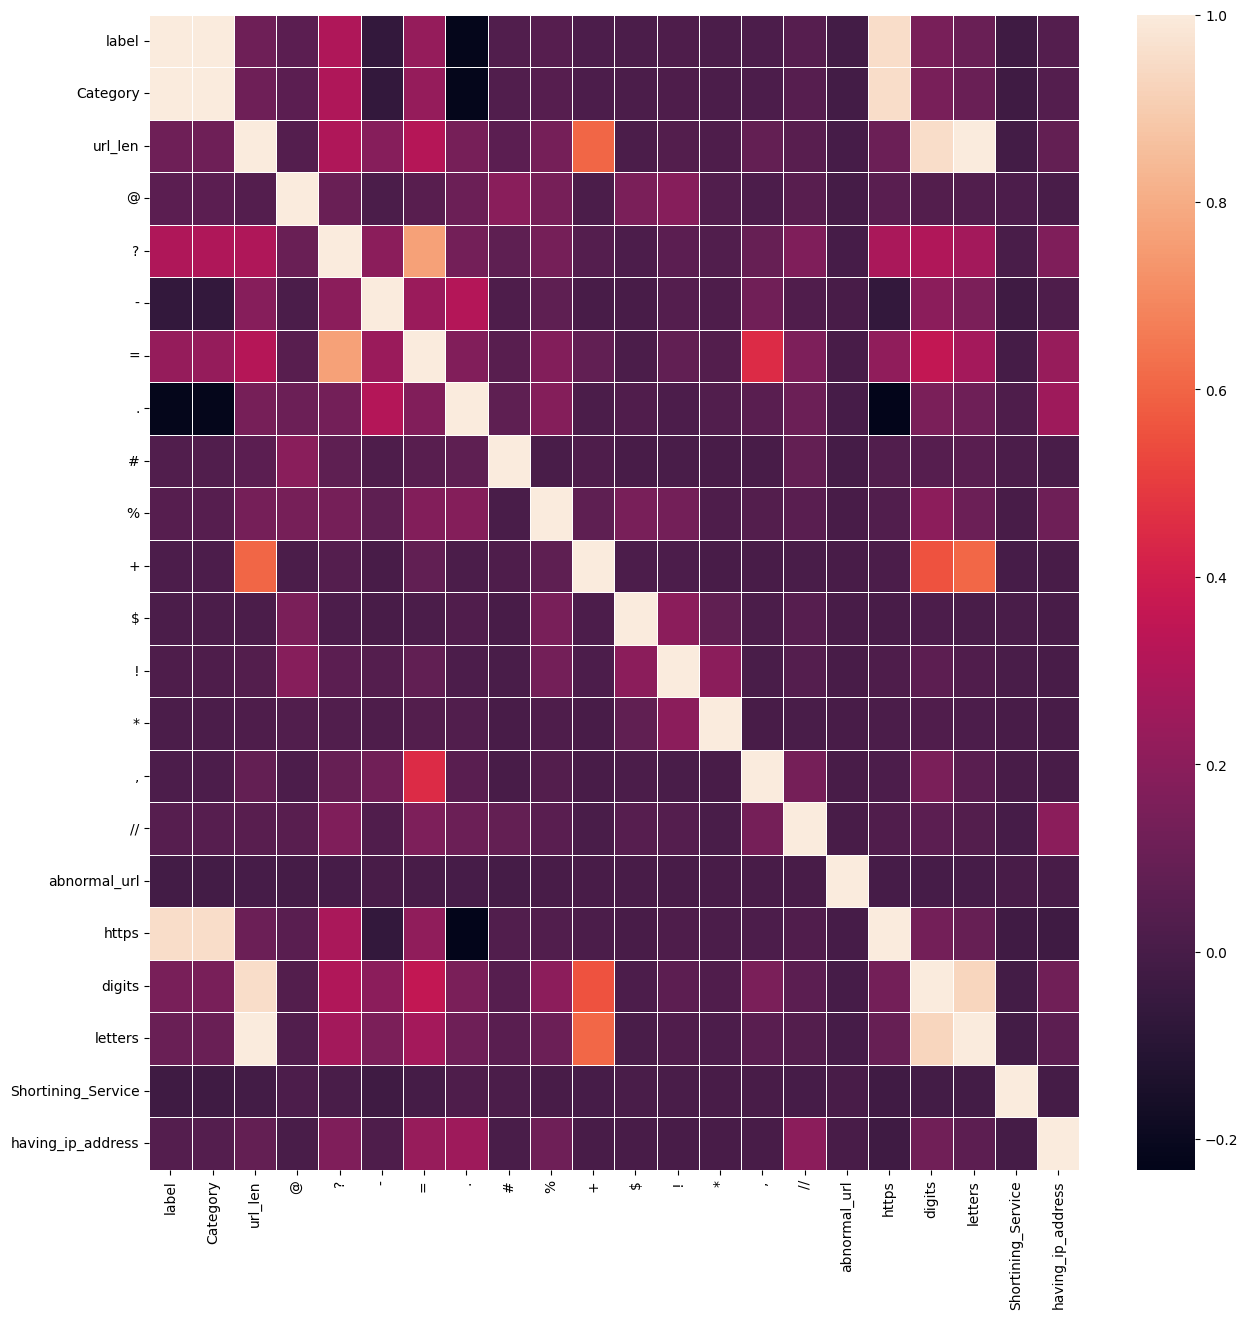

In [30]:
plt.figure(figsize=(15, 15))
numeric_data = data.select_dtypes(include=[np.number])
sns.heatmap(numeric_data.corr(), linewidths=.5)

## 4 · Model Training & Evaluation

Training 5 classifiers on binary (Safe vs Phishing) classification. The top 3 (Decision Tree, Random Forest, Extra Trees) are selected for the production ensemble.

In [31]:
X = data.drop(['url','type','Category','domain'],axis=1)
y = data['Category'].astype(int)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

#############################################
######-Model => <class 'sklearn.tree._classes.DecisionTreeClassifier'> 
Test Accuracy :  100.00%  
              Classification_report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10122
           1       1.00      1.00      1.00     11195

    accuracy                           1.00     21317
   macro avg       1.00      1.00      1.00     21317
weighted avg       1.00      1.00      1.00     21317

             Confusion_matrix 


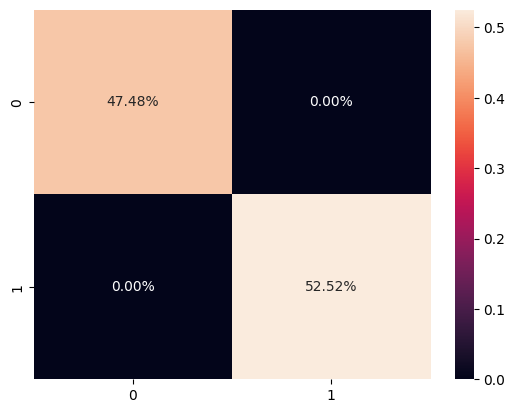

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
Test Accuracy :  100.00%  
              Classification_report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10122
           1       1.00      1.00      1.00     11195

    accuracy                           1.00     21317
   macro avg       1.00      1.00      1.00     21317
weighted avg       1.00      1.00      1.00     21317

             Confusion_matrix 


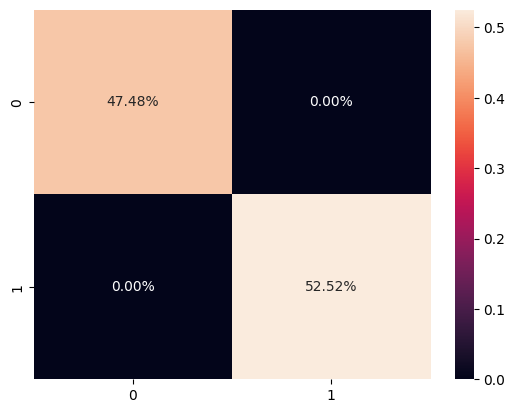

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'> 
Test Accuracy :  100.00%  
              Classification_report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10122
           1       1.00      1.00      1.00     11195

    accuracy                           1.00     21317
   macro avg       1.00      1.00      1.00     21317
weighted avg       1.00      1.00      1.00     21317

             Confusion_matrix 


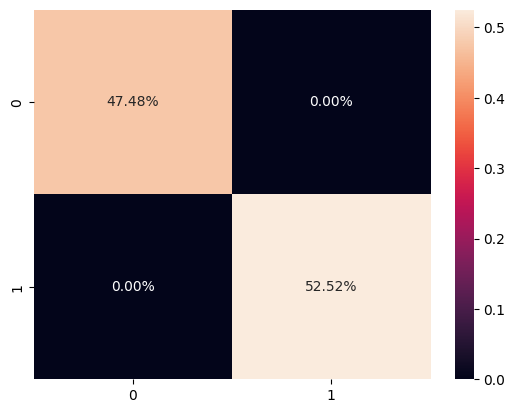

###################- End -###################
#############################################
######-Model => <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> 
Test Accuracy :  99.24%  
              Classification_report 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10122
           1       1.00      0.99      0.99     11195

    accuracy                           0.99     21317
   macro avg       0.99      0.99      0.99     21317
weighted avg       0.99      0.99      0.99     21317

             Confusion_matrix 


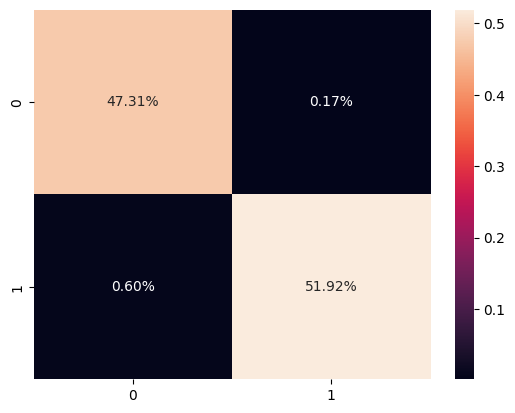

###################- End -###################
#############################################
######-Model => <class 'sklearn.ensemble._forest.ExtraTreesClassifier'> 
Test Accuracy :  100.00%  
              Classification_report 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10122
           1       1.00      1.00      1.00     11195

    accuracy                           1.00     21317
   macro avg       1.00      1.00      1.00     21317
weighted avg       1.00      1.00      1.00     21317

             Confusion_matrix 


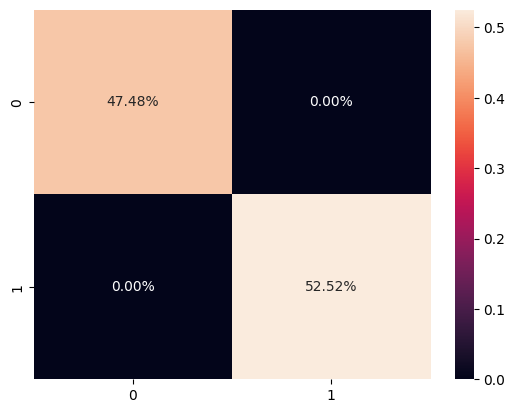

###################- End -###################


In [33]:
models = [DecisionTreeClassifier,RandomForestClassifier,AdaBoostClassifier,SGDClassifier,
         ExtraTreesClassifier]
accuracy_test=[]
for m in models:
    print('#############################################')
    print('######-Model =>\033[07m {} \033[0m'.format(m))
    model_ = m()
    model_.fit(X_train, y_train)
    pred = model_.predict(X_test)
    acc = accuracy_score(pred, y_test)
    accuracy_test.append(acc)
    print('Test Accuracy :\033[32m \033[01m {:.2f}% \033[30m \033[0m'.format(acc*100))
    print('\033[01m              Classification_report \033[0m')
    print(classification_report(y_test, pred))
    print('\033[01m             Confusion_matrix \033[0m')
    cf_matrix = confusion_matrix(y_test, pred)
    plot_ = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt= '0.2%')
    plt.show()
    print('\033[31m###################- End -###################\033[0m')

In [34]:
output = pd.DataFrame({"Model":['Decision Tree Classifier','Random Forest Classifier','AdaBoost Classifier','SGD Classifier','Extra Trees Classifier'],"Accuracy":accuracy_test})

In [35]:
output

,Model,Accuracy
0,Decision Tree Classifier,1.000000
1,Random Forest Classifier,1.000000
2,AdaBoost Classifier,1.000000
3,SGD Classifier,0.992354
4,Extra Trees Classifier,1.000000


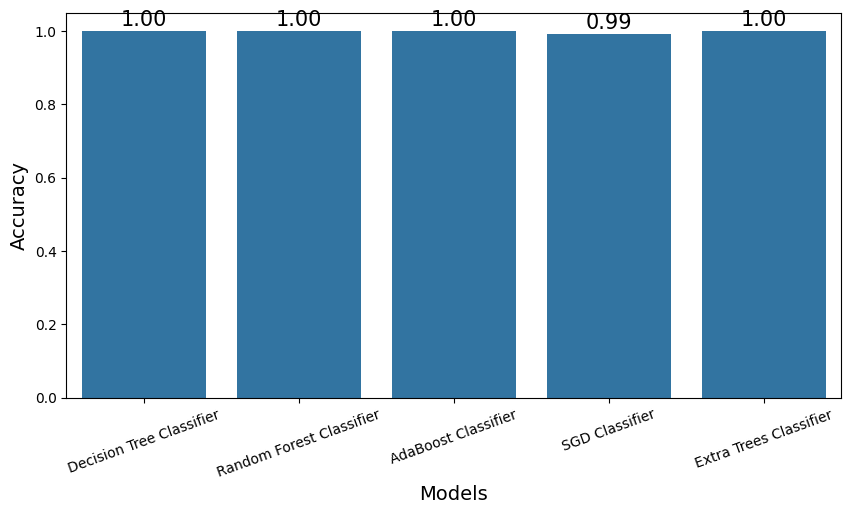

In [36]:
plt.figure(figsize=(10, 5))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models", size=14)
plt.xticks(rotation=20);
plt.ylabel("Accuracy", size=14)
plt.show()

## 5 · Export Models

Save the top-3 binary classifiers to `models/` for the production 6-step pipeline.

In [37]:
# Save the best performing binary classifiers
import joblib
import os

# Create models directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

# Train and save the best models (Decision Tree, Random Forest, Extra Trees)
best_models = [
    ('Decision_Tree_Classifier', DecisionTreeClassifier()),
    ('Random_Forest_Classifier', RandomForestClassifier()),
    ('Extra_Trees_Classifier', ExtraTreesClassifier())
]

print("Saving binary (Safe vs Phishing) models...")
for model_name, model in best_models:
    # Train the model
    model.fit(X_train, y_train)
    
    # Save the model
    model_filename = f'models/{model_name}_URL_Threat_Detection.joblib'
    joblib.dump(model, model_filename)
    
    # Verify accuracy
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    
    print(f"✅ {model_name} saved as '{model_filename}' with {accuracy:.2f} accuracy")

print("\n🎯 All binary models saved successfully!")
print("📁 Models saved in 'models/' directory")
print("🔧 Classes: {0: 'Safe', 1: 'Phishing'}")

Saving binary (Safe vs Phishing) models...
✅ Decision_Tree_Classifier saved as 'models/Decision_Tree_Classifier_URL_Threat_Detection.joblib' with 1.00 accuracy
✅ Random_Forest_Classifier saved as 'models/Random_Forest_Classifier_URL_Threat_Detection.joblib' with 1.00 accuracy
✅ Extra_Trees_Classifier saved as 'models/Extra_Trees_Classifier_URL_Threat_Detection.joblib' with 1.00 accuracy

🎯 All binary models saved successfully!
📁 Models saved in 'models/' directory
🔧 Classes: {0: 'Safe', 1: 'Phishing'}


## 6 · Production Pipeline Testing

Load the saved models from `models/` and run the 6-step pipeline on test URLs.

| Step | Name | Weight |
|------|------|--------|
| 1 | URL Normalization | — |
| 2 | Blocklist & IP Check | — (pre-filter) |
| 3 | Domain Analysis | 20 % |
| 4 | URL Structure | 20 % |
| 5 | Reputation Heuristics | 20 % |
| 6 | ML Classification | 40 % |

**Risk Score** = `ml_score × 0.4 + domain_score × 0.2 + reputation_score × 0.2 + structure_score × 0.2`

> **Production files:**  `App/UrlThreadDetection/url_analyzer_production.py` · `App/UrlThreadDetection/views.py`

In [38]:
# ── Load saved models from the Service directory ──────────────────────────
import joblib, os, time, socket, re
import numpy as np, pandas as pd
from urllib.parse import urlparse, parse_qs, unquote
from collections import Counter

MODELS_DIR = os.path.join(os.getcwd(), 'models')

MODEL_FILES = {
    'Decision Tree':  'Decision_Tree_Classifier_URL_Threat_Detection.joblib',
    'Random Forest':  'Random_Forest_Classifier_URL_Threat_Detection.joblib',
    'Extra Trees':    'Extra_Trees_Classifier_URL_Threat_Detection.joblib',
}

loaded_models = {}
for name, fname in MODEL_FILES.items():
    p = os.path.join(MODELS_DIR, fname)
    if os.path.exists(p):
        loaded_models[name] = joblib.load(p)
        print(f"✅  {name} loaded  ({os.path.getsize(p)/1e6:.1f} MB)")
    else:
        print(f"❌  {name} not found at {p}")

print(f"\n📦  {len(loaded_models)}/{len(MODEL_FILES)} models ready\n")


# ── Threat-intelligence constants ─────────────────────────────────────────

MALICIOUS_TLDS = {
    '.tk','.ml','.ga','.cf','.gq','.pw','.cc','.ws','.info','.biz',
    '.top','.click','.download','.stream','.science','.party','.racing',
    '.win','.loan','.faith','.xyz','.bid','.trade','.webcam',
}

PHISHING_KEYWORDS = [
    'login','signin','verify','secure','update','confirm','suspended',
    'locked','limited','security','alert','urgent','expire','password',
    'credential','authenticate','validate','unlock','recover',
]

TRUSTED_DOMAINS = {
    'google.com','youtube.com','gmail.com','microsoft.com','github.com',
    'stackoverflow.com','wikipedia.org','amazon.com','facebook.com',
    'twitter.com','linkedin.com','apple.com','netflix.com','reddit.com',
    'dropbox.com','zoom.us','slack.com','discord.com','paypal.com',
    'stripe.com','cnn.com','bbc.com','nytimes.com','whitehouse.gov',
    'cdc.gov','nih.gov','nasa.gov','mit.edu','stanford.edu','harvard.edu',
    'coursera.org','edx.org','arxiv.org','pypi.org',
    'chatgpt.com','openai.com','anthropic.com','claude.ai',
}

SHORTENERS = {
    'bit.ly','tinyurl.com','goo.gl','ow.ly','t.co','is.gd','tiny.cc',
    'cutt.ly','rebrand.ly','buff.ly','adf.ly','shorte.st','j.mp','v.gd',
}

BRAND_MAP = {
    'paypal':'paypal.com','amazon':'amazon.com','microsoft':'microsoft.com',
    'google':'google.com','apple':'apple.com','facebook':'facebook.com',
    'netflix':'netflix.com','chase':'chase.com',
}


# ── Feature extraction (matches training columns) ────────────────────────

LEGACY_COLS = [
    'url_len','@','?','-','=','.','#','%','+','$','!','*',',','//',
    'abnormal_url','https','digits','letters','Shortining_Service','having_ip_address',
]

def extract_features(url):
    """Extract the 20 features used during training."""
    orig = url
    if not url.startswith(('http://','https://')): url = 'http://' + url
    parsed = urlparse(url)
    domain = (parsed.netloc or '').lower().replace('www.','',1)

    f = {'url_len': len(orig)}
    for ch in ['@','?','-','=','.','#','%','+','$','!','*',',','//']:
        f[ch] = orig.count(ch)
    f['abnormal_url'] = 1 if domain and domain not in orig else 0
    f['https'] = 1 if orig.startswith('https://') else 0
    f['digits'] = sum(c.isdigit() for c in orig)
    f['letters'] = sum(c.isalpha() for c in orig)
    f['Shortining_Service'] = 1 if any(s in domain for s in SHORTENERS) else 0
    f['having_ip_address'] = 1 if re.search(r'(\d{1,3}\.){3}\d{1,3}', domain) else 0
    return f


# ── Trusted-domain check (7-layer) ───────────────────────────────────────

def is_trusted(url):
    if not url.startswith(('http://','https://')): url = 'http://' + url
    d = urlparse(url).netloc.lower().replace('www.','',1).split(':')[0]
    if d in TRUSTED_DOMAINS: return True, 'exact'
    if any(d.endswith('.'+t) for t in TRUSTED_DOMAINS): return True, 'subdomain'
    if any(d.endswith(t) for t in ['.gov','.edu','.mil','.ac.uk']): return True, 'gov/edu'
    return False, 'unknown'


# ── 6-Step Pipeline ──────────────────────────────────────────────────────

LABEL_MAP = {0: 'Safe', 1: 'Phishing'}
WEIGHTS = {'ml': 0.40, 'domain': 0.20, 'reputation': 0.20, 'structure': 0.20}

def run_pipeline(raw_url):
    """Execute the 6-step URL threat analysis pipeline using saved models."""
    t0 = time.time()
    url = unquote(raw_url.strip())
    if not url.startswith(('http://','https://','ftp://')): url = 'https://' + url
    parsed = urlparse(url)
    domain = (parsed.netloc or '').lower()
    if domain.startswith('www.'): domain = domain[4:]
    domain = re.sub(r':(80|443)$','',domain)

    # Step 1 · Normalization
    print(f"  [1] Normalize     → {domain}  ({parsed.scheme})")

    features = extract_features(url)

    # Step 2 · Blocklist & IP Check (pre-filter, not in scoring)
    bl = 0
    if any(s == domain or domain.endswith('.'+s) for s in SHORTENERS): bl = 25
    if any(p in url.lower() for p in ('data:','javascript:')): bl = 90
    if 'xn--' in domain: bl = max(bl, 30)
    ip_in_url = bool(re.search(r'(\d{1,3}\.){3}\d{1,3}', domain))
    if ip_in_url: bl = max(bl, 40)
    print(f"  [2] Blocklist/IP  → risk {bl}  {'(IP in URL)' if ip_in_url else ''}")

    # Step 3 · Domain Analysis (Trusted + DNS)
    trusted, reason = is_trusted(url)
    di = 50
    try:
        socket.gethostbyname(domain.split(':')[0]); di = 30
    except: di = 65
    domain_score = 5 if trusted else di
    print(f"  [3] Domain        → {'✅ '+reason if trusted else '❔ unknown'}  (risk {domain_score})")

    # Step 4 · Structure
    st = 0
    if features['url_len'] > 200: st += 25
    elif features['url_len'] > 100: st += 10
    if features.get('.', 0) > 4: st += 15
    if features.get('@', 0): st += 20
    st = min(st, 100)
    print(f"  [4] Structure     → risk {st}")

    # Step 5 · Reputation
    rp = 0
    tld = '.'+domain.split('.')[-1] if '.' in domain else ''
    if tld in MALICIOUS_TLDS: rp += 20
    kws = sum(1 for k in PHISHING_KEYWORDS if k in url.lower())
    if kws >= 3: rp += 25
    elif kws >= 1: rp += 10
    for brand, legit in BRAND_MAP.items():
        if brand in domain and domain != legit:
            rp += 35; break
    if not url.startswith('https://'): rp += 10
    rp = min(rp, 100)
    print(f"  [5] Reputation    → risk {rp}")

    # Step 6 · ML classification (using saved models)
    df = pd.DataFrame([features])
    for c in LEGACY_COLS:
        if c not in df.columns: df[c] = 0
    df = df[LEGACY_COLS]

    preds, probs = [], []
    for name, mdl in loaded_models.items():
        try:
            p = mdl.predict(df)[0]
            pr = mdl.predict_proba(df)[0]
            preds.append(p); probs.append(pr)
            print(f"       {name:>14s}: {LABEL_MAP[p]} ({max(pr)*100:.1f}%)")
        except Exception as e:
            print(f"       {name:>14s}: error — {e}")

    ml_risk = 50
    ml_label = 'Unknown'
    if probs:
        avg = np.mean(probs, axis=0)
        ens = int(np.argmax(avg))
        ml_label = LABEL_MAP[ens]
        ml_conf = avg[ens] * 100
        ml_risk = min(95, ml_conf) if ens == 1 else max(5, 100-ml_conf)
    print(f"  [6] ML Ensemble   → {ml_label} (risk {ml_risk:.0f})")

    # ── Weighted risk score (4 components) ────────────────────────────────
    raw = (ml_risk * 0.40 + domain_score * 0.20 + rp * 0.20 + st * 0.20)

    # Override guards
    if trusted: raw = min(raw, 15)
    if bl >= 80: raw = max(raw, 80)
    if ip_in_url and not trusted: raw = max(raw, 50)

    score = int(min(max(round(raw), 0), 100))

    level = 'LOW' if score < 25 else 'MEDIUM' if score < 50 else 'HIGH' if score < 75 else 'CRITICAL'
    verdict = ('SAFE' if (trusted and score < 20) or score < 25
               else 'SUSPICIOUS' if score < 55 else 'MALICIOUS')

    ms = (time.time()-t0)*1000
    icon = {'SAFE':'✅','SUSPICIOUS':'⚠️','MALICIOUS':'🚨'}[verdict]
    print(f"  ── Risk Score     → {score}/100 ({level})")
    print(f"  {icon}  {verdict}  |  ML: {ml_label}  |  {ms:.0f} ms\n")

    return {'url': url, 'domain': domain, 'score': score, 'level': level,
            'verdict': verdict, 'ml': ml_label, 'trusted': trusted}


# ═══════════════════════════════════════════════════════════════════════════
#  TEST SUITE
# ═══════════════════════════════════════════════════════════════════════════

TEST_URLS = [
    # — Legitimate (expect SAFE) —
    'https://www.google.com/search?q=test',
    'https://github.com/microsoft/vscode',
    'https://stackoverflow.com/questions/tagged/python',
    'https://en.wikipedia.org/wiki/Python_(programming_language)',
    'https://www.whitehouse.gov',
    'https://www.mit.edu/academics',
    'https://www.cdc.gov/health',
    'amazon.com/products/books',
    'https://docs.microsoft.com/en-us/azure',
    'https://chatgpt.com',
    # — Suspicious / Malicious (expect non-SAFE) —
    'http://192.168.1.100/malware.exe',
    'bit.ly/suspicious-link-2024',
    'http://phishing-paypal-login.tk/secure',
    'fake-microsoft-login.ml/verify-account',
    'amazon-security-update.gq/confirm',
    'payp4l-security.com/login',
    'g00gle-drive-share.net/files',
    'micr0soft-update.biz/download',
]

LEGIT_COUNT = 10  # first 10 are legitimate

print('🚀  URL Threat Detection v3.0 — 6-Step Pipeline Test')
print('='*60, '\n')

results = [run_pipeline(u) for u in TEST_URLS]

# ── Summary ───────────────────────────────────────────────────────────────
safe_ok = sum(1 for r in results[:LEGIT_COUNT] if r['verdict']=='SAFE')
mal_ok  = sum(1 for r in results[LEGIT_COUNT:] if r['verdict']!='SAFE')
total   = safe_ok + mal_ok
total_n = len(TEST_URLS)

print('='*60)
print('📊  SUMMARY')
print('='*60)
print(f'  Legitimate correct:  {safe_ok}/{LEGIT_COUNT}')
print(f'  Malicious  detected: {mal_ok}/{len(TEST_URLS)-LEGIT_COUNT}')
print(f'  Overall accuracy:    {total}/{total_n} ({total/total_n*100:.0f}%)')
tag = '🎉 EXCELLENT' if total/total_n >= .85 else '✅ GOOD' if total/total_n >= .75 else '⚠️ NEEDS WORK'
print(f'  {tag}')
print(f'\n📦  Models dir: {MODELS_DIR}')
print(f'🌐  Production: App/UrlThreadDetection/views.py')

✅  Decision Tree loaded  (0.0 MB)
✅  Random Forest loaded  (1.0 MB)
✅  Extra Trees loaded  (0.4 MB)

📦  3/3 models ready

🚀  URL Threat Detection v3.0 — 6-Step Pipeline Test

  [1] Normalize     → google.com  (https)
  [2] Blocklist/IP  → risk 0  
  [3] Domain        → ✅ exact  (risk 5)
  [4] Structure     → risk 0
  [5] Reputation    → risk 0
        Decision Tree: error — The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- label

        Random Forest: error — The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- label

          Extra Trees: error — The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- label

  [6] ML Ensemble   → Unknown (risk 50)
  ── Risk Score     → 15/100 (LOW)
  ✅  SAFE  |  ML: Unknown  |  18 ms

  [1] Normalize     → github.com  (https)
  [2] Blocklist/IP  → risk 0  
  [3